In [18]:
import numpy as np, pandas as pd, tensorflow as tf
from sklearn.preprocessing import MinMaxScaler
import matplotlib.pyplot as plt

# 1. 데이터 로드
df = pd.read_csv(r"C:\Users\yale3\OneDrive\바탕 화면\대학\3학년2학기\기학프\Alcohol_Sales.csv")
data = df['S4248SM144NCEN'].values.reshape(-1,1)


In [19]:
# 2. 정규화
scaler = MinMaxScaler()
data = scaler.fit_transform(data)

In [20]:
# 3. 시퀀스 생성
window = 12   # 최근 12개월 → 다음달 예측
X, y = [], []
for i in range(len(data)-window):
    X.append(data[i:i+window])
    y.append(data[i+window])
X, y = np.array(X), np.array(y)



In [21]:
# 6. Train/Test 분할 (누수 방지) + 시퀀스 생성
# /test=70/30, window=12 기준
from sklearn.preprocessing import MinMaxScaler

window = 12  # 필요 시 조정
train_ratio = 0.7
val_ratio = 0.1  # 검증 비율
series = df['S4248SM144NCEN'].values.reshape(-1, 1)
split_idx_train = int(len(series) * train_ratio)
split_idx_val = int(len(series) * (train_ratio + val_ratio))

scaler_ts = MinMaxScaler()
train_raw = series[:split_idx_train]
val_raw_start = max(0, split_idx_train - window)
val_raw = series[val_raw_start:split_idx_val]
test_raw_start = max(0, split_idx_val - window)
test_raw = series[test_raw_start:]

train_scaled = scaler_ts.fit_transform(train_raw)
val_scaled = scaler_ts.transform(val_raw)
test_scaled = scaler_ts.transform(test_raw)

def make_sequences(arr, win):
    X, y = [], []
    for i in range(win, len(arr)):
        X.append(arr[i - win:i])
        y.append(arr[i])
    return np.array(X), np.array(y)

X_train, y_train = make_sequences(train_scaled, window)
X_val,  y_val  = make_sequences(val_scaled, window)
X_test, y_test = make_sequences(test_scaled, window)

print('훈련 데이터의 크기 :', X_train.shape, y_train.shape)
print('검증 데이터의 크기 :', X_val.shape, y_val.shape)
print('테스트 데이터의 크기 :', X_test.shape, y_test.shape)


훈련 데이터의 크기 : (215, 12, 1) (215, 1)
검증 데이터의 크기 : (33, 12, 1) (33, 1)
테스트 데이터의 크기 : (65, 12, 1) (65, 1)


In [22]:
# 7. 모델 A: RNN (SimpleRNN) 학습 및 MSE 평가
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import SimpleRNN, LSTM, Dense, Dropout
from tensorflow.keras.metrics import MeanSquaredError

rnn_model = Sequential([
    SimpleRNN(20, activation='tanh', return_sequences=True, input_shape=X_train.shape[1:]),
    Dropout(0.3),
    SimpleRNN(20, activation='tanh'),
    Dropout(0.3),
    Dense(1)
])
rnn_model.compile(optimizer='adam', loss='mse', metrics=['mse'])
rnn_model.summary()

hist_rnn = rnn_model.fit(
    X_train, y_train,
    epochs=50, batch_size=16,
    validation_data=(X_val, y_val),
    verbose=1
)
rnn_mse = rnn_model.evaluate(X_test, y_test, verbose=0)[0]
print(f'RNN Test MSE: {rnn_mse:.6f}')
pred_rnn = rnn_model.predict(X_test)


c:\Users\yale3\AppData\Local\Programs\Python\Python313\Lib\site-packages\keras\src\layers\rnn\rnn.py:199: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


Model: "sequential_5"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ simple_rnn_6 (SimpleRNN)        │ (None, 12, 20)         │           440 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_8 (Dropout)             │ (None, 12, 20)         │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ simple_rnn_7 (SimpleRNN)        │ (None, 20)             │           820 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_9 (Dropout)             │ (None, 20)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_5 (Dense)                 │ (None, 1)              │            21 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 1,281 (5.00 KB)

 Trainable params: 1,281 (5.00 KB)

 Non-trainable params: 0 (0.00 B)

Epoch 1/50
14/14 ━━━━━━━━━━━━━━━━━━━━ 2s 28ms/step - loss: 0.2876 - mse: 0.2876 - val_loss: 0.0591 - val_mse: 0.0591
Epoch 2/50
14/14 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - loss: 0.1590 - mse: 0.1590 - val_loss: 0.1001 - val_mse: 0.1001
Epoch 3/50
14/14 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - loss: 0.1349 - mse: 0.1349 - val_loss: 0.0917 - val_mse: 0.0917
Epoch 4/50
14/14 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - loss: 0.0907 - mse: 0.0907 - val_loss: 0.0350 - val_mse: 0.0350
Epoch 5/50
14/14 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - loss: 0.0846 - mse: 0.0846 - val_loss: 0.0391 - val_mse: 0.0391
Epoch 6/50
14/14 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - loss: 0.0760 - mse: 0.0760 - val_loss: 0.0419 - val_mse: 0.0419
Epoch 7/50
14/14 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - loss: 0.0626 - mse: 0.0626 - val_loss: 0.0338 - val_mse: 0.0338
Epoch 8/50
14/14 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - loss: 0.0556 - mse: 0.0556 - val_loss: 0.0221 - val_mse: 0.0221
Epoch 9/50
14/14 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - loss: 0.0468 - mse:

In [23]:
# 8. 모델 B: LSTM 학습 및 MSE 평가
lstm_model = Sequential([
    LSTM(20, activation='tanh', return_sequences=True, input_shape=X_train.shape[1:]),
    Dropout(0.3),
    LSTM(20, activation='tanh'),
    Dropout(0.3),
    Dense(1)
])
lstm_model.compile(optimizer='adam', loss='mse', metrics=['mse'])
lstm_model.summary()

hist_lstm = lstm_model.fit(
    X_train, y_train,
    epochs=50, batch_size=16,
    validation_data=(X_val, y_val),
    verbose=1
)
lstm_mse = lstm_model.evaluate(X_test, y_test, verbose=0)[0]
print(f'LSTM Test MSE: {lstm_mse:.6f}')
pred_lstm = lstm_model.predict(X_test)


Model: "sequential_6"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ lstm_4 (LSTM)                   │ (None, 12, 20)         │         1,760 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_10 (Dropout)            │ (None, 12, 20)         │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ lstm_5 (LSTM)                   │ (None, 20)             │         3,280 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_11 (Dropout)            │ (None, 20)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_6 (Dense)                 │ (None, 1)              │            21 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 5,061 (19.77 KB)

 Trainable params: 5,061 (19.77 KB)

 Non-trainable params: 0 (0.00 B)

Epoch 1/50
14/14 ━━━━━━━━━━━━━━━━━━━━ 3s 34ms/step - loss: 0.1460 - mse: 0.1460 - val_loss: 0.1483 - val_mse: 0.1483
Epoch 2/50
14/14 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step - loss: 0.0358 - mse: 0.0358 - val_loss: 0.0243 - val_mse: 0.0243
Epoch 3/50
14/14 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step - loss: 0.0255 - mse: 0.0255 - val_loss: 0.0711 - val_mse: 0.0711
Epoch 4/50
14/14 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step - loss: 0.0273 - mse: 0.0273 - val_loss: 0.0399 - val_mse: 0.0399
Epoch 5/50
14/14 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step - loss: 0.0186 - mse: 0.0186 - val_loss: 0.0377 - val_mse: 0.0377
Epoch 6/50
14/14 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step - loss: 0.0203 - mse: 0.0203 - val_loss: 0.0316 - val_mse: 0.0316
Epoch 7/50
14/14 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step - loss: 0.0206 - mse: 0.0206 - val_loss: 0.0314 - val_mse: 0.0314
Epoch 8/50
14/14 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step - loss: 0.0219 - mse: 0.0219 - val_loss: 0.0256 - val_mse: 0.0256
Epoch 9/50
14/14 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step - loss: 0.016

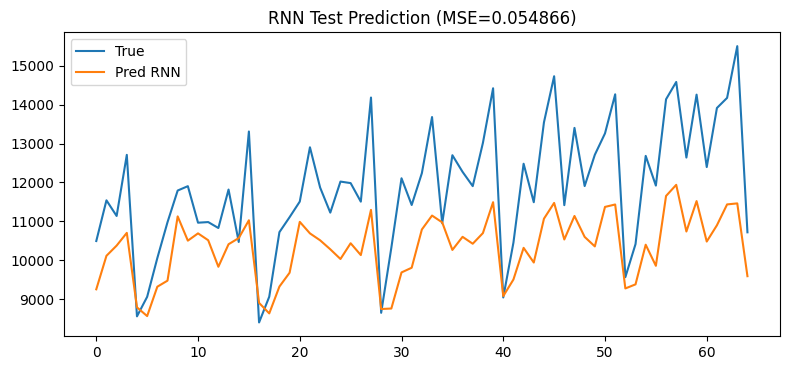

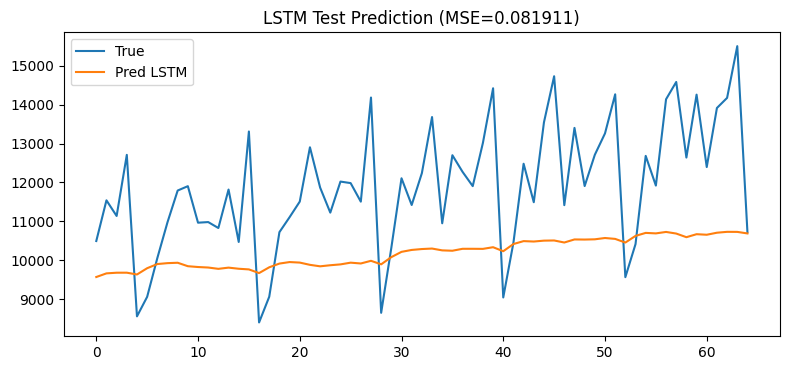

In [24]:
# 9. 역정규화 및 그래프 2개 (RNN/LSTM 각각)
y_test_inv    = scaler_ts.inverse_transform(y_test)
pred_rnn_inv  = scaler_ts.inverse_transform(pred_rnn)
pred_lstm_inv = scaler_ts.inverse_transform(pred_lstm)

import matplotlib.pyplot as plt
plt.figure(figsize=(8, 3.8))
plt.plot(y_test_inv, label='True')
plt.plot(pred_rnn_inv, label='Pred RNN')
plt.title('RNN Test Prediction (MSE={:.6f})'.format(rnn_mse))
plt.legend(); plt.tight_layout(); plt.show()

plt.figure(figsize=(8, 3.8))
plt.plot(y_test_inv, label='True')
plt.plot(pred_lstm_inv, label='Pred LSTM')
plt.title('LSTM Test Prediction (MSE={:.6f})'.format(lstm_mse))
plt.legend(); plt.tight_layout(); plt.show()


In [25]:
# 10. RNN/LSTM MSE 함께 출력
print(f"RNN Test MSE: {rnn_mse:.6f}")
print(f"LSTM Test MSE: {lstm_mse:.6f}")
better = 'RNN' if rnn_mse < lstm_mse else 'LSTM'
print(f"Better (lower MSE): {better}")


RNN Test MSE: 0.054866
LSTM Test MSE: 0.081911
Better (lower MSE): RNN
